# 8.1 Robust BIM microchip production problem

## Preamble: Install Pyomo and a solver

This cell selects and verifies various global solvers for the notebook. In this notebook, we need the MILO solver `HiGHS`, but also the NLO solver `ipopt` and the MINLO solvers `bonmin` or `gurobi` to deal with nonlinear optimization problems. We install the latter two using the IDAES module and its extensions, which include the pre-compiled binary for these solvers.

In [ ]:
import os
%pip install idaes-pse --pre >/dev/null 2>/dev/null
%pip install highspy >/dev/null 2>/dev/null
!idaes get-extensions --to ./bin 
os.environ['PATH'] += ':bin'

solver = "appsi_highs"
NLO_solver = "ipopt"
MINLO_solver = "gurobi_direct" # alternative: "bonmin"

import pyomo.environ as pyo

SOLVER = pyo.SolverFactory(solver)
NLO_SOLVER = pyo.SolverFactory(NLO_solver)
MINLO_SOLVER = pyo.SolverFactory(MINLO_solver)

assert SOLVER.available(), f"Solver {solver} is not available."
assert NLO_SOLVER.available(), f"Solver {NLO_solver} is not available."
assert MINLO_SOLVER.available(), f"Solver {MINLO_solver} is not available."

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import fractions

## Original BIM production planning model

The full description of the BIM production problem, can be found [here](../02/01-bim.ipynb). The resulting linear optimization problem was formulated as follows:

$$
\begin{array}{rrcrcl}
\max    & 12x_1 & + & 9x_2               \\
\text{s.t.}    &   x_1 &   &      & \leq & 1000 \\
        &       &   &  x_2 & \leq & 1500 \\
        &   x_1 & + &  x_2 & \leq & 1750 \\
        &  4x_1 & + & 2x_2 & \leq & 4800 \\
        &   x_1 & , &  x_2 & \geq & 0.
\end{array}
$$

In [28]:
chips = ["logic", "memory"]
profits = {"logic": 12, "memory": 9}
copper = {"logic": 4, "memory": 2}

m = pyo.ConcreteModel("BIM basic problem")

m.chips = pyo.Set(initialize=chips)
m.x = pyo.Var(m.chips, within=pyo.NonNegativeReals)

m.profit = pyo.Objective(
    expr=pyo.quicksum([profits[c] * m.x[c] for c in m.chips]),
    sense=pyo.maximize,
)

m.silicon = pyo.Constraint(expr=m.x["logic"] <= 1000)
m.gemanium = pyo.Constraint(expr=m.x["memory"] <= 1500)
m.plastic = pyo.Constraint(expr=pyo.quicksum([m.x[c] for c in m.chips]) <= 1750)
m.copper = pyo.Constraint(
    expr=pyo.quicksum(copper[c] * m.x[c] for c in m.chips) <= 4800
)

SOLVER.solve(m)
print(
    f"The optimal solution is x={[round(pyo.value(m.x[c]),3) for c in m.chips]} and yields a profit of {pyo.value(m.profit):.2f}"
)

The optimal solution is x=[650.0, 1100.0] and yields a profit of 17700.00


In [29]:
def ShowDuals(model):
    print("The dual variable corresponding to:")
    for c in model.component_objects(pyo.Constraint, active=True):
        print(
            f"- the constraint on {c} is equal to {str(fractions.Fraction(model.dual[c]))}"
        )


m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
SOLVER.solve(m)
ShowDuals(m)

The dual variable corresponding to:
- the constraint on silicon is equal to 0
- the constraint on gemanium is equal to 0
- the constraint on plastic is equal to 6
- the constraint on copper is equal to 3/2


## Robust BIM production planning models

Suppose now that there is uncertainty affecting the microchip production at BIM. Specifically, the company notices that not the amount of copper needed for the two types of microchips is not _exactly_ 4 and 2 gr, but varies due to some external factors affecting the production process. How does this uncertainty affect the optimal production plan?

To get a feeling for what happens, let us first perform some simulations and data analysis on them. We start by simulating a sample of $n=2000$ observed copper consumption pairs for the production of `f` logic chips and `g` memory chips. The amounts vary around the original values, 4 gr and 2 gr, respectively, according to two independent lognormal distributions.

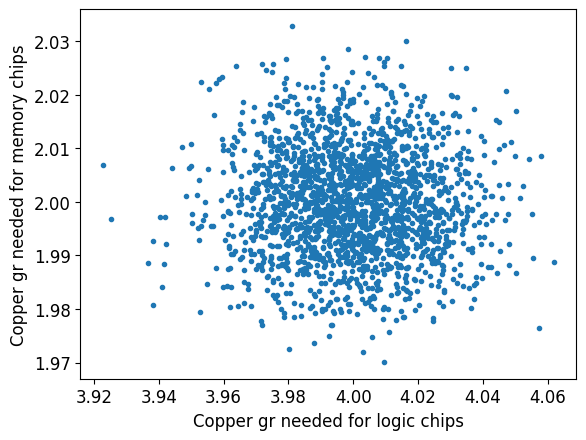

In [30]:
plt.rcParams.update({"font.size": 12})

seed = 0
rng = np.random.default_rng(seed)
n = 2000

f = rng.lognormal(np.log(4.0), 0.005, n)
g = rng.lognormal(np.log(2.0), 0.005, n)

plt.figure()
plt.plot(f, g, ".")
plt.xlabel("Copper gr needed for logic chips")
plt.ylabel("Copper gr needed for memory chips")
plt.show()

### Box uncertainty for copper consumption

A very simple and somehow naive uncertainty set can be the minimal box that contains all the simulated data.

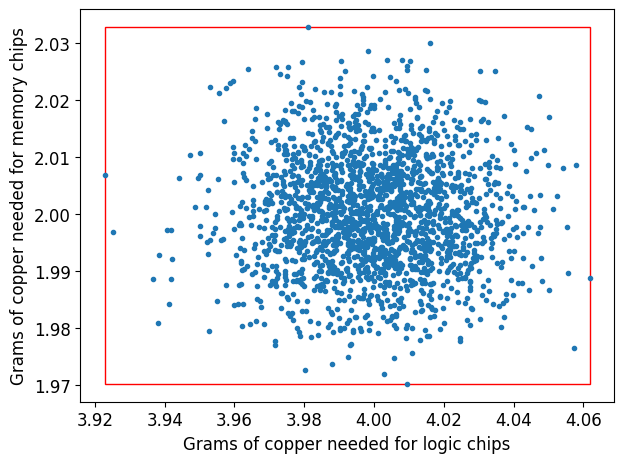

Lower bounds {'logic': 3.922766922829344, 'memory': 1.9701110863753781}
Upper bounds {'logic': 4.061793174956137, 'memory': 2.0328386701386703}


In [31]:
plt.figure()
plt.plot(f, g, ".")
currentAxis = plt.gca()
currentAxis.add_patch(
    patches.Rectangle(
        (min(f), min(g)),
        max(f) - min(f),
        max(g) - min(g),
        fill=False,
        color="r",
    )
)
plt.xlabel("Grams of copper needed for logic chips")
plt.ylabel("Grams of copper needed for memory chips")
plt.tight_layout()
plt.show()

# calculate the upper and lower bounds for each uncertain parameter
lower = {"logic": min(f), "memory": min(g)}
upper = {"logic": max(f), "memory": max(g)}
print("Lower bounds", lower)
print("Upper bounds", upper)

Using this empirical box uncertainty set, we can consider the following robust variant of their optimization model:

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
\text{s.t.}    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & z_1 x_1 & + & z_2 x_2 & \leq & 4800 & \forall \ell \leq a \leq u \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

The above model has an infinite number of constraints, one for every realization of the uncertain coefficients $z$. However, using linear duality, we can deal with this and obtain a robustified linear optimization problem that we can solve. 

### Robust counterpart of box uncertainty

The first thing to notice is that the copper consumption is modeled by constraints that are equivalent to bounding the following optimization problem:
    
$$
\begin{array}{rrr}
\max    & x_1 z_1 + x_2 z_2 & \leq 4800 \\
\text{s.t.}    & \ell \leq z \leq u 
\end{array}
$$

or

$$
\begin{array}{rrr}
\max    & x_1 z_1 + x_2 z_2 & \leq 4800 \\
\text{s.t.}    & z \leq u \\
        & -z \leq -\ell.
\end{array}
$$

Now we use linear duality to realize that the above is equivalent to:
 
$$
\begin{array}{rrr}
\min    & u y  - \ell w & \leq 4800 \\
\text{s.t.}    & y - w = x \\
        & y \geq 0, w \geq 0
\end{array}
$$
    
and the constraint imposed by the last problem is equivalent to:

$$
\begin{array}{rrl}
   & u y  - \ell w & \leq 4800 \\
   & y - w & = x \\
   & y \geq 0, w \geq 0
\end{array}
$$

The only thing we need to do is add the new auxiliary variables and constraints to the original model and implement them in Pyomo.

In [32]:
def BIMWithBoxUncertainty(lower, upper, domain=pyo.NonNegativeReals):
    m = pyo.ConcreteModel("BIM with Box Uncertainty")

    m.chips = pyo.Set(initialize=chips)
    m.x = pyo.Var(m.chips, within=domain)

    m.profit = pyo.Objective(
        expr=sum([profits[c] * m.x[c] for c in m.chips]), sense=pyo.maximize
    )

    m.silicon = pyo.Constraint(expr=m.x["logic"] <= 1000)
    m.germanium = pyo.Constraint(expr=m.x["memory"] <= 1500)
    m.plastic = pyo.Constraint(expr=sum([m.x[c] for c in m.chips]) <= 1750)

    m.y = pyo.Var(m.chips, domain=pyo.NonNegativeReals)
    m.w = pyo.Var(m.chips, domain=pyo.NonNegativeReals)

    m.robustcopper = pyo.Constraint(
        expr=sum([upper[c] * m.y[c] - lower[c] * m.w[c] for c in m.chips]) <= 4800
    )

    @m.Constraint(m.chips)
    def PerVariable(m, c):
        return m.x[c] == m.y[c] - m.w[c]

    return m


m = BIMWithBoxUncertainty(lower, upper)
SOLVER.solve(m)

print(
    f"The optimal solution is x={[round(pyo.value(m.x[c]),3) for c in m.chips]} and yields a profit of {pyo.value(m.profit):.2f}"
)

The optimal solution is x=[612.4, 1137.6] and yields a profit of 17587.20


We may want to impose the box uncertainty set to be symmetric with respect to the nominal values and just choose its width $\delta$. This leads to a different optimal robust solution.

In [33]:
# The parameter delta allows you to tune the amount of uncertainty.
# In particular, if you take delta=0, you obtain the same result as the nominal model.
delta = 0.05


def BIMWithSymmetricalBoxUncertainty(delta, domain=pyo.NonNegativeReals):
    lower = {chip: copper[chip] - delta for chip in chips}
    upper = {chip: copper[chip] + delta for chip in chips}
    return BIMWithBoxUncertainty(lower, upper, domain=domain)


m = BIMWithSymmetricalBoxUncertainty(delta)
SOLVER.solve(m)

print(
    f"The optimal solution is x={[round(pyo.value(m.x[c]),3) for c in m.chips]} and yields a profit of {pyo.value(m.profit):.2f}"
)

The optimal solution is x=[606.25, 1143.75] and yields a profit of 17568.75


### Integer solution variant

The original BIM model gave integer solutions, but not the robust version. If we need integer solutions then we should impose that to the nature of the variables, which in this case of _box uncertainty_ is easy to do since the model remains linear, although it will be mixed integer. 

In [34]:
m = BIMWithBoxUncertainty(lower, upper, domain=pyo.NonNegativeIntegers)
SOLVER.solve(m)

print(
    f"The optimal solution is x={[round(pyo.value(m.x[c]),3) for c in m.chips]} and yields a profit of {pyo.value(m.profit):.2f}"
)

The optimal solution is x=[612.0, 1138.0] and yields a profit of 17586.00


Let us see how the optimal solution behave as we vary the width of the box uncertainty set $\delta$ from 0 to 0.5. 

In [35]:
df = pd.DataFrame()
for delta in np.linspace(0, 0.5, 21):
    m = BIMWithSymmetricalBoxUncertainty(delta, domain=pyo.NonNegativeIntegers)
    SOLVER.solve(m)
    results = [pyo.value(m.profit)] + [pyo.value(m.x[i]) for i in m.chips]
    df.at[delta, "profit"] = results[0]
    df.at[delta, chips[0]] = results[1]
    df.at[delta, chips[1]] = results[2]
df

,profit,logic,memory
0.000,17700.0,650.0,1100.0
0.025,17634.0,628.0,1122.0
0.050,17568.0,606.0,1144.0
0.075,17502.0,584.0,1166.0
0.100,17436.0,562.0,1188.0
0.125,17370.0,540.0,1210.0
0.150,17304.0,518.0,1232.0
0.175,17238.0,496.0,1254.0
0.200,17175.0,475.0,1275.0
0.225,17109.0,453.0,1297.0


We can visualize how these quantities change as a function of $\delta$:

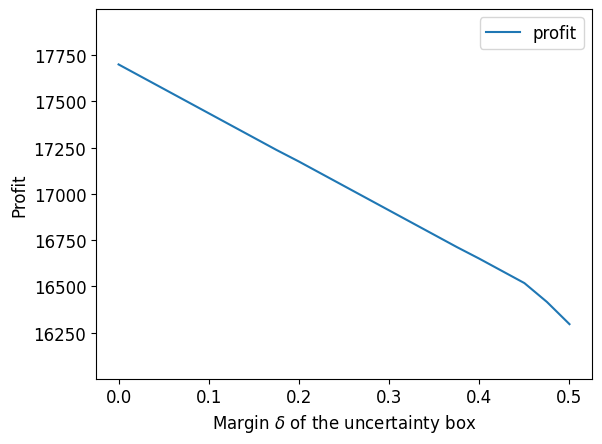

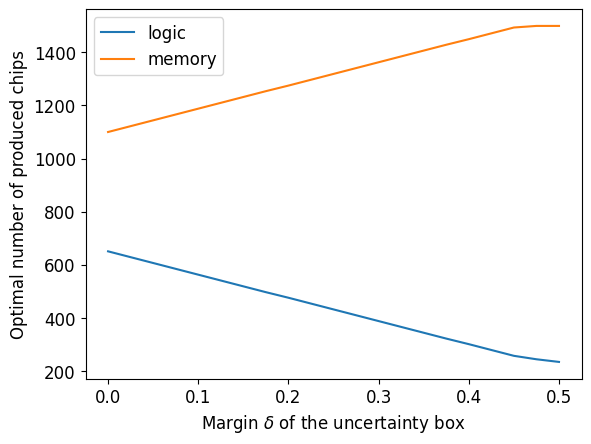

In [36]:
df[["profit"]].plot()
plt.ylim([16001, 17999])
plt.xlabel("Margin $\delta$ of the uncertainty box")
plt.ylabel("Profit")
plt.show()
df[["logic", "memory"]].plot()
plt.xlabel("Margin $\delta$ of the uncertainty box")
plt.ylabel("Optimal number of produced chips")
plt.show()

## Cardinality-constrained uncertainty set

Let us now make different assumptions regarding the uncertainty related to the copper consumption. More specifically, we now assume that each uncertain coefficient $z_j$ may deviate by at most $\pm \delta$ from the nominal value $\bar{z}_j$ but no more than $\Gamma$ will actually deviate.

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
\text{s.t.}    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & z_1 x_1 & + & z_2 x_2 & \leq & 4800 & \forall \, y \in \mathbb{R}^2 \,:\, z_j=\bar{z}_j+\delta y_j, \, \|y\|_\infty \leq 1, \, \|y\|_1\leq \Gamma \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

### Robust counterpart of cardinality-constrained uncertainty
Lagrange duality yields the following modification to the problem as equivalent to the robust model stated above:

$$
\begin{array}{rrcrcrcrcrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
\text{s.t.}    &     x_1 &   &         & & & & & & & \leq & 1000 \\
        &         &   &     x_2 & & & & & & & \leq & 1500 \\
        &     x_1 & + &     x_2 & & & & & & & \leq & 1750 \\
        & \bar{z}_1 x_1 & + & \bar{z}_2 x_2 & + & \lambda\Gamma & + & t_1 & + & t_2 & \leq & 4800 \\
        &-\delta x_1 &   &         & + & \lambda & + & t_1 &   &     & \geq & 0 \\
        &         &   &-\delta x_2 & + & \lambda &   &     & + & t_2 & \geq & 0 \\
        &\delta x_1 &   &         & + & \lambda & + & t_1 &   &     & \geq & 0 \\
        &         &   &\delta x_2 & + & \lambda &   &     & + & t_2 & \geq & 0 \\
        &     x_1 & , &     x_2 & , & \lambda & , & t_1 & , & t_2 & \geq & 0    \\
\end{array}
$$

In [37]:
def BIMWithBudgetUncertainty(delta, gamma, domain=pyo.NonNegativeReals):
    m = pyo.ConcreteModel("BIM with Budget Uncertainty")

    m.chips = pyo.Set(initialize=chips)
    m.x = pyo.Var(m.chips, domain=domain)

    m.profit = pyo.Objective(
        expr=sum([profits[c] * m.x[c] for c in m.chips]), sense=pyo.maximize
    )

    m.silicon = pyo.Constraint(expr=m.x["logic"] <= 1000)
    m.germanium = pyo.Constraint(expr=m.x["memory"] <= 1500)
    m.plastic = pyo.Constraint(expr=sum([m.x[c] for c in m.chips]) <= 1750)

    m.t = pyo.Var(m.chips, domain=pyo.NonNegativeReals)
    m.lam = pyo.Var(domain=pyo.NonNegativeReals)

    m.robustcopper = pyo.Constraint(
        expr=sum([copper[c] * m.x[c] for c in m.chips])
        + gamma * m.lam
        + sum(m.t[c] for c in m.chips)
        <= 4800
    )

    @m.Constraint(m.chips)
    def up_rule(m, c):
        return m.t[c] >= delta * m.x[c] - m.lam

    @m.Constraint(m.chips)
    def down_rule(m, c):
        return m.t[c] >= -delta * m.x[c] - m.lam

    return m


m = BIMWithBudgetUncertainty(0.01, 2, domain=pyo.NonNegativeIntegers)
SOLVER.solve(m)

print(
    f"The optimal solution is x={[round(pyo.value(m.x[c]),3) for c in m.chips]} and yields a profit of {pyo.value(m.profit):.2f}"
)

The optimal solution is x=[641.0, 1109.0] and yields a profit of 17673.00


### Adversarial approach for the budgeted uncertainty set

Instead of adopting the approach of robust counterparts, we could also use the adversarial approach where we initially solve the problem for the nominal value of the data. Then, we iteratively search for scenarios that make the current solution violate the copper constraint, and pre-solve the problem to take this scenario into account. To do so, we need to slightly modify our problem formulation function to allow for many scenarios for the parameter $z$.

In [38]:
def BIMWithSetOfScenarios(
    delta, Z=[{"logic": 0, "memory": 0}], domain=pyo.NonNegativeReals
):
    chips = ["logic", "memory"]
    profits = {"logic": 12, "memory": 9}
    copper = {"logic": 4, "memory": 2}

    m = pyo.ConcreteModel("BIM basic problem")

    m.chips = pyo.Set(initialize=chips)
    m.scenarios = pyo.Set(initialize=range(len(Z)))
    m.x = pyo.Var(m.chips, within=pyo.NonNegativeReals)

    m.profit = pyo.Objective(
        expr=pyo.quicksum([profits[c] * m.x[c] for c in m.chips]),
        sense=pyo.maximize,
    )

    m.silicon = pyo.Constraint(expr=m.x["logic"] <= 1000)
    m.gemanium = pyo.Constraint(expr=m.x["memory"] <= 1500)
    m.plastic = pyo.Constraint(expr=pyo.quicksum([m.x[c] for c in m.chips]) <= 1750)

    @m.Constraint(m.scenarios)
    def balance(m, i):
        z = Z[i]
        return pyo.quicksum(copper[c] * m.x[c] * (1 + z[c]) for c in m.chips) <= 4800

    return m

We also need a function that for a given solution finds the worst-possible realization of the uncertainty restricted by the parameters $\Gamma$ and $\delta$. In other words, its role is to solve the following maximization problem for a given solution $(\bar{x}_1, \bar{x}_2)$:

$$
\begin{align*}
\max \ & (\bar{z}_1 + \delta y_1) \bar{x}_1 + (\bar{z}_2 + \delta y_2) \bar{x}_2 - 4800 \\
\text{s.t.} \ & |y_1| + |y_2| \leq \Gamma \\
& -1 \leq y_i \leq 1 && i = 1, 2.
\end{align*}
$$

Such a function is implemented below and takes as argument also the maximum magnitude of the individual deviations $\delta$ and the total budget $\Gamma$.

In [39]:
def BIMPessimization(x, delta, gamma):
    chips = ["logic", "memory"]
    copper = {"logic": 4, "memory": 2}

    m = pyo.ConcreteModel("BIM pessimization problem")
    m.chips = pyo.Set(initialize=chips)
    m.z = pyo.Var(m.chips, within=pyo.Reals)
    m.u = pyo.Var(m.chips, within=pyo.NonNegativeReals)

    @m.Constraint(m.chips)
    def absolute_value_1(m, i):
        return m.z[i] <= m.u[i]

    @m.Constraint(m.chips)
    def absolute_value_2(m, i):
        return -m.z[i] <= m.u[i]

    @m.Constraint(m.chips)
    def absolute_value_less_than_one(m, i):
        return m.u[i] <= 1.0

    m.budget_constraint = pyo.Constraint(
        expr=pyo.quicksum([m.u[i] for i in m.chips]) <= gamma
    )
    m.violation = pyo.Objective(
        expr=-4800
        + pyo.quicksum([copper[c] * x[c] * (1 + delta * m.z[c]) for c in m.chips]),
        sense=pyo.maximize,
    )

    return m

We wrap the two functions above into a loop of the adversarial approach, which begins with a non-perturbation assumption and gradually generates violating scenarios, reoptimizing until the maximum constraint violation is below a tolerable threshold.

In [40]:
# Parameters
adversarial_converged = False
stopping_precision = 0.1
max_iterations = 5
adversarial_iterations = 0
delta = 0.2
gamma = 1.5
chips = ["logic", "memory"]

# Initialize the null scenario - no perturbation
Z = [{"logic": 0, "memory": 0}]

while (not adversarial_converged) and (adversarial_iterations < max_iterations):
    # Building and solving the master problem
    model = BIMWithSetOfScenarios(delta, Z, domain=pyo.NonNegativeIntegers)
    SOLVER.solve(model)

    # Saving the current solution
    x = {i: model.x[i]() for i in model.chips}

    print(f"\nIteration #{adversarial_iterations}")
    print(f"Current solution: ")
    for c in chips:
        print(f"x['{c}']= {x[c]:.2f}")

    # Pessimization
    m = BIMPessimization(x, delta, gamma)
    SOLVER.solve(m)

    worst_z = {i: m.z[i]() for i in chips}
    constraint_violation = m.violation()

    # If pessimization yields no violation, stop the procedure, otherwise add a scenario and repeat
    if constraint_violation < stopping_precision:
        print("No violation found. Stopping the procedure.")
        adversarial_converged = True
    else:
        print(
            f"Violation found: z['logic'] = {worst_z['logic']},  z['memory'] = {worst_z['memory']}, "
            f"constraint violation: {constraint_violation:6.2f}"
        )
        Z.append(worst_z)

    adversarial_iterations += 1


Iteration #0
Current solution: 
x['logic']= 650.00
x['memory']= 1100.00
Violation found: z['logic'] = 1.0,  z['memory'] = 0.5, constraint violation: 740.00

Iteration #1
Current solution: 
x['logic']= 37.50
x['memory']= 1500.00
No violation found. Stopping the procedure.


It takes only two scenarios to be added to the baseline scenario to arrive at the solution which is essentially robust! For that reason, in many settings the adversarial approach is very viable. In fact, because the budgeted uncertainty set for two uncertain parameters has at most 8 vertices, we are guaranteed that it would never take more than 8 iterations to reach a fully robust solution (constraint violation of exactly $0$).

This is not true, however, if the uncertainty set is not a polytope, but is, for example, an ellipsoid (ball) with infinitely many extreme points - it is expected that there will always be some minuscule constraint violation remaining after a certain number of iterations. 

We will now illustrate how to use conic optimization to solve the problem using robust counterparts for an ellipsoidal uncertainty set.

## Ball uncertainty set

Let us now make yet another different assumption regarding the uncertainty related to copper consumption. More specifically, we assume that the two uncertain coefficients $z_1$ and $z_2$ can vary in a 2-dimensional ball centered around the point $(\bar{z}_1,\bar{z}_2) = (4,2)$ and with radius $r$. 

### Robust counterpart of ball uncertainty
A straightforward reformulation leads to the equivalent constraint:

$$
  \bar{z}_1x_1+\bar{z}_2x_2 + r \|x\|_2 \leq 4800
$$

By defining $y = 4800 - \bar{z}_1x_1 - \bar{z}_2x_2$ and $w = r x$, we may write:

$$
  \|w\|^2_2 \leq y^2
$$

We now need to add this newly obtained conic constraint to the original BIM model. The [Pyomo documentation](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/conic.html) says a conic constraint is expressed in 'pyomo' in simple variables and this [table](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/syntax_comparison.html) reports the syntax.

In [41]:
import pyomo.kernel as pyk


def BIMWithBallUncertainty(radius, domain_type=pyk.RealSet):
    idxChips = range(len(chips))

    m = pyk.block()

    m.x = pyk.variable_list()
    for i in idxChips:
        m.x.append(pyk.variable(lb=0, domain=domain_type))

    m.profit = pyk.objective(
        expr=sum(profits[chips[i]] * m.x[i] for i in idxChips),
        sense=pyk.maximize,
    )

    m.silicon = pyk.constraint(expr=m.x[0] <= 1000)
    m.germanium = pyk.constraint(expr=m.x[1] <= 1500)
    m.plastic = pyk.constraint(expr=sum([m.x[i] for i in idxChips]) <= 1750)

    m.y = pyk.variable(lb=0)
    m.w = pyk.variable_list()
    for i in idxChips:
        m.w.append(pyk.variable(lb=0))

    m.copper = pyk.constraint(
        expr=m.y == 4800 - sum(copper[chips[i]] * m.x[i] for i in idxChips)
    )

    m.xtow = pyk.constraint_list()
    for i in idxChips:
        m.xtow.append(pyk.constraint(expr=m.w[i] == radius * m.x[i]))

    from pyomo.core.kernel.conic import quadratic

    m.robust = quadratic(m.y, m.w)

    return m

Now the optimization problem is nonlinear, but dedicated solvers can leverage the fact that is conic and solve it efficiently. Specifically, `cplex`, `gurobi` and `xpress` support second-order cones. On the other hand, `ipopt` is a generic solver for nonlinear optimization problems.

In [49]:
radius = 0.05
m = BIMWithBallUncertainty(radius)

results = pyk.SolverFactory(NLO_solver).solve(m)
print(
    f"Solver: {NLO_solver}, solver status:",
    results.solver.status,
    "and solver terminal condition:",
    results.solver.termination_condition,
)
print(
    f"The optimal solution is x={[round(pyk.value(m.x[i]), 3) for i in range(len(m.x))]} and yields a profit of {pyo.value(m.profit):.2f}"
)

Solver: ipopt, solver status: ok and solver terminal condition: optimal
The optimal solution is x=[617.755, 1132.245] and yields a profit of 17603.26


The solvers `bonmin`, `cplex`, `gurobi` and `xpress` are capable of solving the mixed integer version of the same model: 

In [48]:
m = BIMWithBallUncertainty(radius, domain_type=pyk.IntegerSet)

results = pyk.SolverFactory(MINLO_solver).solve(m)
print(
    f"Solver: {MINLO_solver}, solver status:",
    results.solver.status,
    "and solver terminal condition:",
    results.solver.termination_condition,
)
print(
    f"The optimal solution is x={[round(pyk.value(m.x[i]), 3) for i in range(len(m.x))]} and yields a profit of {pyo.value(m.profit):.2f}"
)

Solver: gurobi_direct, solver status: ok and solver terminal condition: optimal
The optimal solution is x=[617.0, 1133.0] and yields a profit of 17601.00


### Implementing second-order cones using `pyomo.environ`

Noting that $\| x \| \leq t$ is for $t \geq 0$ equivalent to $\| x \|^2 \leq t^2$ and knowing that the commercial solvers (`gurobi`, `cplex` and `express`) support convex quadratic inequalities, we can model this variant in `pyomo.environ` as follows. Note that the essential part to make the model convex is having the right hand side nonnegative.

In [44]:
def BIMWithBallUncertaintyAsSquaredSecondOrderCone(r, domain=pyo.NonNegativeReals):
    m = pyo.ConcreteModel("BIM with Ball Uncertainty as SOC")

    m.chips = pyo.Set(initialize=chips)
    m.x = pyo.Var(m.chips, within=domain)

    # the nonnegativity of this variable is essential!
    m.y = pyo.Var(within=pyo.NonNegativeReals)

    m.profit = pyo.Objective(
        expr=sum([profits[c] * m.x[c] for c in m.chips]), sense=pyo.maximize
    )

    m.silicon = pyo.Constraint(expr=m.x["logic"] <= 1000)
    m.germanium = pyo.Constraint(expr=m.x["memory"] <= 1500)
    m.plastic = pyo.Constraint(expr=sum([m.x[c] for c in m.chips]) <= 1750)
    m.copper = pyo.Constraint(
        expr=m.y == 4800 - sum(copper[c] * m.x[c] for c in m.chips)
    )
    m.robust = pyo.Constraint(expr=sum((r * m.x[c]) ** 2 for c in m.chips) <= m.y**2)

    return m

In [50]:
m = BIMWithBallUncertaintyAsSquaredSecondOrderCone(radius)

results = NLO_SOLVER.solve(m)
print(
    f"Solver: {NLO_solver}, solver status:",
    results.solver.status,
    "and solver terminal condition:",
    results.solver.termination_condition,
)
print(
    f"The optimal solution is x={[round(pyo.value(m.x[c]),3) for c in m.chips]} and yields a profit of {pyo.value(m.profit):.2f}"
)

Solver: ipopt, solver status: ok and solver terminal condition: optimal
The optimal solution is x=[617.755, 1132.245] and yields a profit of 17603.26


In [51]:
m = BIMWithBallUncertaintyAsSquaredSecondOrderCone(
    radius, domain=pyo.NonNegativeIntegers
)

results = MINLO_SOLVER.solve(m)
print(
    f"Solver: {MINLO_solver}, solver status:",
    results.solver.status,
    "and solver terminal condition:",
    results.solver.termination_condition,
)
print(
    f"The optimal solution is x={[round(pyo.value(m.x[c]),3) for c in m.chips]} and yields a profit of {pyo.value(m.profit):.2f}"
)

Solver: gurobi_direct, solver status: ok and solver terminal condition: optimal
The optimal solution is x=[617.0, 1133.0] and yields a profit of 17601.00
